In [1]:
import numpy as np
from astroquery.mast import Catalogs
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
ticid = 156359520

starName = "TIC " + str(ticid)
radSearch = 4/60 #radius in degrees

catalogData = Catalogs.query_object(starName, radius = radSearch, catalog = "TIC")
ra = catalogData[0]['ra']
dec = catalogData[0]['dec']

# Print out the first row in the table
print( catalogData[:5]['ID', 'Tmag', 'Jmag', 'ra', 'dec', 'objType'] )

    ID      Tmag   Jmag         ra              dec        objType
--------- ------- ------ ---------------- ---------------- -------
156359520 15.4394  12.67  86.900618632173 9.28267284355118    STAR
715777761 16.6678     -- 86.9002291207406 9.28727977896371    STAR
156359527 13.6864 12.818 86.9007170167323 9.28764049805394    STAR
715777762 19.6639     -- 86.9065966864421 9.28543570309231    STAR
156390629 18.2461 16.261 86.9090634648955 9.28515173592599    STAR


In [3]:
# Create a list of nearby bright stars (tess magnitude less than 14) from the rest of the data for later.
bright = catalogData['Tmag'] < 15

# Make it a list of Ra, Dec pairs of the bright ones. This is now a list of nearby bright stars.
nearbyStars = list( map( lambda x,y:[x,y], catalogData[bright]['ra'], catalogData[bright]['dec'] ) )
len(nearbyStars)

20

In [4]:
coord = SkyCoord(ra, dec, unit = "deg")

sectorTable = Tesscut.get_sectors(coord)
print(sectorTable)

  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0006-1-4      6      1   4


In [5]:
hdulist = Tesscut.get_cutouts(coord, 20)

In [6]:
hdulist[0].info()
hdulist[0][0].header['SECTOR']

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   ()      
  1  PIXELS        1 BinTableHDU    279   993R x 12C   [D, E, J, 400J, 400E, 400E, 400E, 400E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU       147   (20, 20)   int32   


6

In [7]:
# Define a function to simplify the plotting command that we do repeatedly.
def plot_cutout(image):
    """
    Plot image and add grid lines.
    """
    plt.imshow(image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
           vmax = np.percentile(image, 92),
           vmin = np.percentile(image, 5))

    plt.grid(axis = 'both',color = 'white', ls = 'solid')

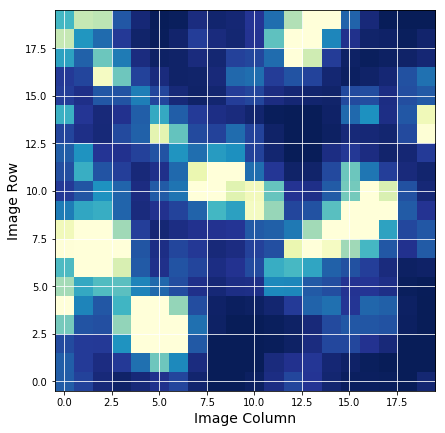

In [8]:
hdu1 = hdulist[0]
firstImage = hdu1[1].data['FLUX'][0]

fig = plt.figure(figsize=(7, 7))
plot_cutout(firstImage)
plt.xlabel('Image Column',fontsize = 14)
plt.ylabel('Image Row',fontsize = 14)
plt.show()

In [9]:
def aperture_phot(image, aperture):
    """
    Sum-up the pixels that are in the aperture for one image.
    image and aperture are 2D arrays that need to be the same size.
    
    aperture is a boolean array where True means to include the light of those pixels.
    """
    flux = np.sum(image[aperture])

    return flux

def make_lc(flux_data, aperture):
    """
    Apply the 2d aperture array to the and time series of 2D images. 
    Return the photometric series by summing over the pixels that are in the aperture.
    
    Aperture is a boolean array where True means it is in the desired aperture.
    """
    
    flux = np.array(list (map (lambda x: aperture_phot(x, aperture), flux_data) ) )

    return flux

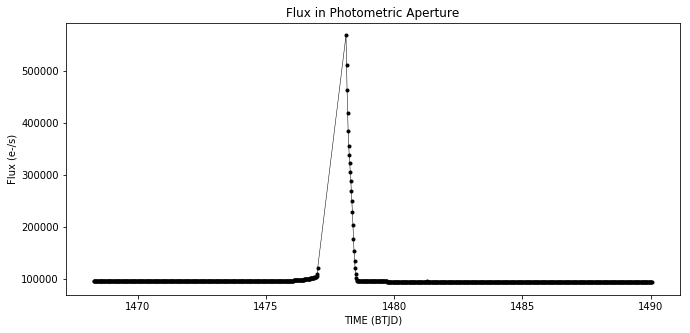

In [10]:
# Use all pixels in our aperture.
aperture = hdu1[2].data == 1

flux1 = make_lc(hdu1[1].data['FLUX'], aperture)
time1 = hdu1[1].data['TIME']

plt.figure(figsize = (11,5))
plt.plot(time1, flux1, 'k.-', lw = .5)
#plt.xlim(1325,1342)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Flux (e-/s)')
plt.title('Flux in Photometric Aperture')
plt.show()

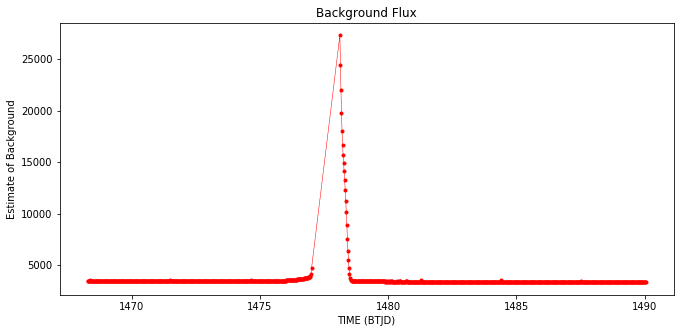

In [11]:
# Plot the flux change of the dimmest pixels by using percentile.
bkgAperture = hdu1[1].data['FLUX'][0] < np.percentile(hdu1[1].data['FLUX'][0], 5)

bkgFlux1 = make_lc(hdu1[1].data['FLUX'], bkgAperture)
time1 = hdu1[1].data['TIME']

plt.figure(figsize = (11, 5))
plt.plot(time1, bkgFlux1, 'r.-', lw = .5)

#plt.xlim(1325, 1342)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Estimate of Background')
plt.title('Background Flux')
plt.show()

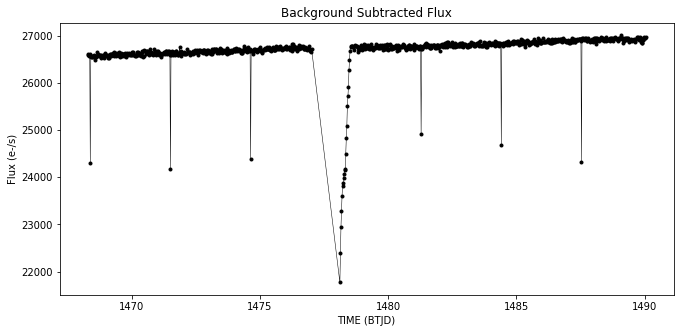

In [12]:
bkgSubFlux = flux1 - (bkgFlux1 * np.sum(aperture) / np.sum(bkgAperture) )

plt.figure(figsize = (11,5))
plt.plot(time1, bkgSubFlux,'.-k', lw = 0.5)

#plt.xlim(1325, 1336)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Flux (e-/s)')
plt.title('Background Subtracted Flux')
plt.show()

In [13]:
import numpy as np
from astropy.io import fits
import requests
from astroquery.mast import Catalogs
import zipfile
from astropy.wcs import WCS
import matplotlib.pyplot as plt

%matplotlib inline

urlroot = "https://mast.stsci.edu/tesscut/api/v0.1"

In [14]:
ticid = 156359520

starName = "TIC " + str(ticid)
radSearch = 5 / 60 # radius in degrees

catalogData = Catalogs.query_object(starName, radius = radSearch, catalog = "TIC")
Ra = catalogData[0]['ra']
Dec = catalogData[0]['dec']

# Print out the first five rows in the table
print( catalogData[:5]['ID', 'Tmag', 'Jmag', 'ra', 'dec', 'objType'] )

    ID      Tmag   Jmag         ra              dec        objType
--------- ------- ------ ---------------- ---------------- -------
156359520 15.4394  12.67  86.900618632173 9.28267284355118    STAR
715777761 16.6678     -- 86.9002291207406 9.28727977896371    STAR
156359527 13.6864 12.818 86.9007170167323 9.28764049805394    STAR
715777762 19.6639     -- 86.9065966864421 9.28543570309231    STAR
156390629 18.2461 16.261 86.9090634648955 9.28515173592599    STAR


In [15]:
# Create a list of nearby bright stars (tess magnitude less than 14) from the rest of the data for later.
bright = catalogData['Tmag'] < 14

# Make it a list of Ra, Dec pairs of the bright ones. So this is now a list of nearby bright stars.
nearbyStars = list( map( lambda x,y:[x,y], catalogData[bright]['ra'], catalogData[bright]['dec'] ) )
len(nearbyStars)

19

In [16]:
url = urlroot + "/sector"

myparams = {"ra":Ra, "dec":Dec, "radius":"0m"}

requestData = requests.get(url = url, params = myparams)

print(requestData.headers.get('content-type'))

application/json; charset=UTF-8


In [17]:
sectors = requestData.json()['results']
print(sectors)

[{'sectorName': 'tess-s0006-1-4', 'sector': '0006', 'camera': '1', 'ccd': '4'}]


In [18]:
myparams = {"ra":Ra, "dec":Dec, "x":35, "y":45, 
           "units":"px", "sector":"All"}

url = urlroot + "/astrocut"

r = requests.get(url = url, params = myparams)

print(r)
print(r.headers.get('content-type'))

<Response [200]>
application/zip


In [19]:
open('astrocut.zip', 'wb').write(r.content)

31398032

In [20]:
zipRef = zipfile.ZipFile('astrocut.zip','r')
zipRef.extractall('.')
zipRef.close()

# Get list of cuotut names
cutoutnames = zipRef.namelist()
print(cutoutnames)

['tess-s0006-1-4_86.900619_9.282673_35x45_astrocut.fits']


In [21]:
file1 = cutoutnames[0]
fits.info(file1)

Filename: tess-s0006-1-4_86.900619_9.282673_35x45_astrocut.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      56   ()      
  1  PIXELS        1 BinTableHDU    279   993R x 12C   [D, E, J, 1575J, 1575E, 1575E, 1575E, 1575E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU       147   (35, 45)   int32   


In [22]:
hdu1 = fits.open(file1)
hdu1[1].columns

ColDefs(
    name = 'TIME'; format = 'D'; unit = 'BJD - 2457000, days'; disp = 'D14.7'
    name = 'TIMECORR'; format = 'E'; unit = 'd'; disp = 'E14.7'
    name = 'CADENCENO'; format = 'J'; disp = 'I10'
    name = 'RAW_CNTS'; format = '1575J'; unit = 'count'; null = -1; disp = 'I8'; dim = '(35, 45)'
    name = 'FLUX'; format = '1575E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(35, 45)'
    name = 'FLUX_ERR'; format = '1575E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(35, 45)'
    name = 'FLUX_BKG'; format = '1575E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(35, 45)'
    name = 'FLUX_BKG_ERR'; format = '1575E'; unit = 'e-/s'; disp = 'E14.7'; dim = '(35, 45)'
    name = 'QUALITY'; format = 'J'; disp = 'B16.16'
    name = 'POS_CORR1'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'POS_CORR2'; format = 'E'; unit = 'pixel'; disp = 'E14.7'
    name = 'FFI_FILE'; format = '38A'; unit = 'pixel'
)

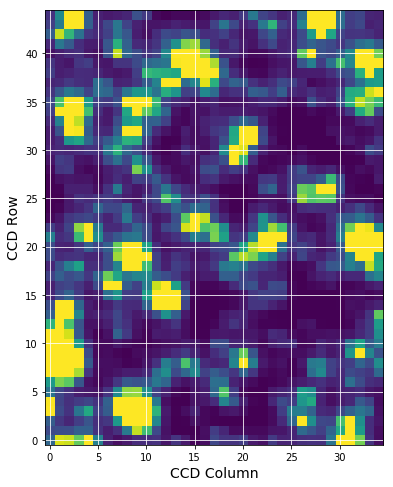

In [23]:
firstImage = hdu1[1].data['FLUX'][0]
fig = plt.figure(figsize=(8,8))
plt.imshow(firstImage, origin = 'lower', cmap = plt.cm.viridis, \
           vmax = np.percentile(firstImage,92), vmin = np.percentile(firstImage,5))
plt.xlabel('CCD Column', fontsize = 14)
plt.ylabel('CCD Row', fontsize = 14)
plt.grid(axis = 'both', color = 'white', ls = 'solid')

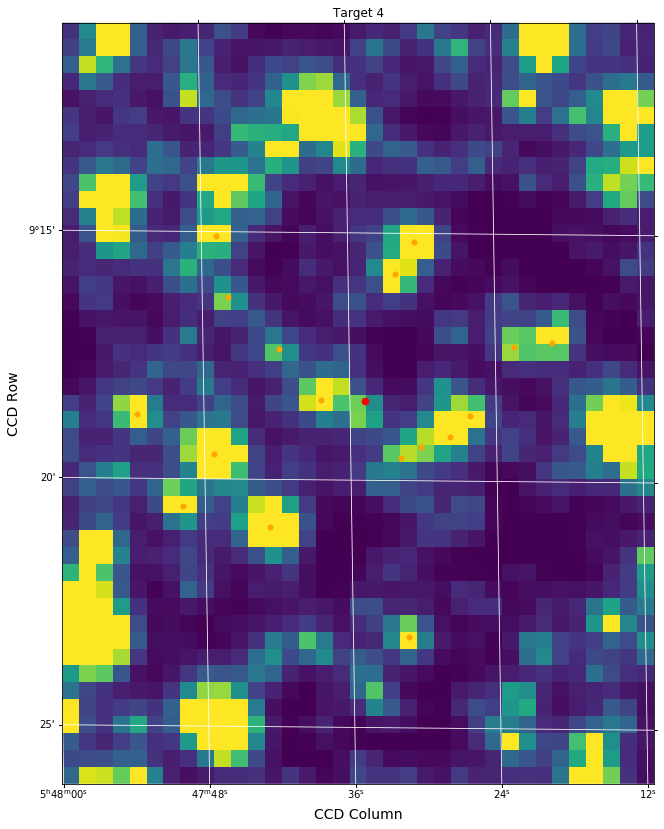

In [25]:
wcs = WCS(hdu1[2].header)

fig = plt.figure(figsize = (14,14))
fig.add_subplot(111, projection = wcs)
plt.imshow(firstImage, origin = 'lower', cmap = plt.cm.viridis, vmax = np.percentile(firstImage,92),\
           vmin = np.percentile(firstImage,5))

plt.xlabel('CCD Column', fontsize = 14)
plt.ylabel('CCD Row', fontsize = 14)
plt.grid(axis = 'both', color = 'white', ls = 'solid')

starLoc = wcs.all_world2pix([[Ra,Dec]],0)  #Second is origin
plt.scatter(starLoc[0,0], starLoc[0,1], s = 45, color = 'red')

# Plot nearby stars as well, which we created using our Catalog call above.
nearbyLoc = wcs.all_world2pix(nearbyStars[1:], 0)
plt.scatter(nearbyLoc[1:,0], nearbyLoc[1:,1], s = 25, color = 'orange')
plt.title("Target 4")
plt.show()